In [1]:
import pandas as pd

In [2]:
chemin = 'C:\\Users\\Sdis59\\Documents\\OpenClassroom\\scoring\\Data\\home-credit-default-risk\\'

le_df = pd.read_csv(chemin + 'df_pour_modélisation.csv')

In [3]:
le_df.shape

(307507, 194)

In [4]:
le_df.columns

Index(['Unnamed: 0', 'SK_ID_CURR', 'TARGET', 'CODE_GENDER', 'FLAG_OWN_CAR',
       'FLAG_OWN_REALTY', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CREDIT',
       'REGION_POPULATION_RELATIVE',
       ...
       'WALLSMATERIAL_MODE_Mixed', 'WALLSMATERIAL_MODE_Monolithic',
       'WALLSMATERIAL_MODE_Others', 'WALLSMATERIAL_MODE_Panel',
       'WALLSMATERIAL_MODE_Stone, brick', 'WALLSMATERIAL_MODE_Wooden',
       'WALLSMATERIAL_MODE_nan', 'EMERGENCYSTATE_MODE_No',
       'EMERGENCYSTATE_MODE_Yes', 'EMERGENCYSTATE_MODE_nan'],
      dtype='object', length=194)

In [5]:
le_df.drop('Unnamed: 0',
           axis = 1,
           inplace = True)

In [6]:
le_df.columns

Index(['SK_ID_CURR', 'TARGET', 'CODE_GENDER', 'FLAG_OWN_CAR',
       'FLAG_OWN_REALTY', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CREDIT',
       'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH',
       ...
       'WALLSMATERIAL_MODE_Mixed', 'WALLSMATERIAL_MODE_Monolithic',
       'WALLSMATERIAL_MODE_Others', 'WALLSMATERIAL_MODE_Panel',
       'WALLSMATERIAL_MODE_Stone, brick', 'WALLSMATERIAL_MODE_Wooden',
       'WALLSMATERIAL_MODE_nan', 'EMERGENCYSTATE_MODE_No',
       'EMERGENCYSTATE_MODE_Yes', 'EMERGENCYSTATE_MODE_nan'],
      dtype='object', length=193)

On va séparer le jeu en un jeu test et un jeu d'entrainement

In [7]:
from sklearn import model_selection

X = le_df[[col for col in le_df.columns if col != 'TARGET']]
y = le_df['TARGET']

X_entrainement, X_test, y_entrainement, y_test = model_selection.train_test_split(X,
                                                                                  y,
                                                                                  test_size = 0.3,
                                                                                  random_state = 500)

In [8]:
X_entrainement.shape

(215254, 192)

In [9]:
y_entrainement.shape

(215254,)

In [10]:
X_test.shape

(92253, 192)

On regarde la répartition des valeurs 0 et 1 des y test et entrainement

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

données = pd.DataFrame(columns = {'0',
                                  '1'},
                       index = ('test',
                                'entrainement'))
données['0']['test'] = np.round(100 * y_test[y_test == 0].count() / y_test.shape[0],
                                2)
données['1']['test'] = np.round(100 * y_test[y_test == 1].count() / y_test.shape[0],
                                2)
données['0']['entrainement'] = np.round(100 * y_entrainement[y_entrainement == 0].count() / y_entrainement.shape[0],
                                2)
données['1']['entrainement'] = np.round(100 * y_entrainement[y_entrainement == 1].count() / y_entrainement.shape[0],
                                2)                               
données
# plt.figure(figsize = (10,5))
# plt.hist(données,
#          bins = 2)
# plt.title('Répartition des cibles des jeux test et entrainement')
# plt.show()

,1,0
test,8.06,91.94
entrainement,8.08,91.92


La répartition des cibles est bonne entre les jeux.

In [12]:
from sklearn.model_selection import StratifiedKFold

On va tester différents modèles à l'aide gridsearchCV.
On va travailler sur un classificateur naïf, deux arbres et un réseau neuronal.
Et calculer deux estimateur  : le béta score et l'AUC.

Tout d'abord, on sélectionne les meilleurs paramètres de chaque modèle avant de leur applique SMOTE et de les comparer.

In [13]:
from sklearn.model_selection import GridSearchCV
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline
from sklearn import metrics
import time

In [14]:
def teste_modèle(X_à_traiter,
                 X_à_tester,
                 y_à_traiter,
                 y_à_tester, 
                 le_modèle,
                 les_paramètres,
                 nombre_validations_croisées, 
                 les_estimateurs) :
    
    la_grille = GridSearchCV(estimator = le_modèle,
                             param_grid = les_paramètres, 
                             cv = nombre_validations_croisées, 
                             n_jobs = 1, 
                             scoring = les_estimateurs,
                             verbose = 3,
                             refit = 'ROC')

    le_modèle_ajusté = la_grille.fit(X_à_traiter,
                                     y_à_traiter)
    les_valeurs_prédites = le_modèle_ajusté.predict(X_à_tester)
    
    return le_modèle_ajusté, les_valeurs_prédites

Classificateur naïf 

In [15]:
classificateur_naïf = DummyClassifier(random_state = 500)

les_paramètres_naïf = {'strategy' : ['most_frequent',
                                     'prior',
                                     'stratified',
                                     'uniform']}

cotation = {'f1' : 'f1',
            'exactitude' : 'accuracy',
            'sensibilté': 'recall',
            'précision' : 'precision',
            'ROC' : 'roc_auc'}

classificateur_naïf, prédictions_naïf = teste_modèle(X_entrainement, 
                                                     X_test,
                                                     y_entrainement,
                                                     y_test,
                                                     classificateur_naïf, 
                                                     les_paramètres_naïf,
                                                     5,
                                                     cotation)

print('Meilleur AUC : ',
      classificateur_naïf.best_score_)
print('Meilleurs paramètres :',
      classificateur_naïf.best_params_)            

Fitting 5 folds for each of 4 candidates, totalling 20 fits


C:\Users\Sdis59\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV 1/5] END strategy=most_frequent; ROC: (test=0.500) exactitude: (test=0.919) f1: (test=0.000) précision: (test=0.000) sensibilté: (test=0.000) total time=   0.3s


C:\Users\Sdis59\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV 2/5] END strategy=most_frequent; ROC: (test=0.500) exactitude: (test=0.919) f1: (test=0.000) précision: (test=0.000) sensibilté: (test=0.000) total time=   0.3s


C:\Users\Sdis59\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV 3/5] END strategy=most_frequent; ROC: (test=0.500) exactitude: (test=0.919) f1: (test=0.000) précision: (test=0.000) sensibilté: (test=0.000) total time=   0.2s
[CV 4/5] END strategy=most_frequent; ROC: (test=0.500) exactitude: (test=0.919) f1: (test=0.000) précision: (test=0.000) sensibilté: (test=0.000) total time=   0.1s


C:\Users\Sdis59\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Sdis59\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV 5/5] END strategy=most_frequent; ROC: (test=0.500) exactitude: (test=0.919) f1: (test=0.000) précision: (test=0.000) sensibilté: (test=0.000) total time=   0.1s
[CV 1/5] END strategy=prior; ROC: (test=0.500) exactitude: (test=0.919) f1: (test=0.000) précision: (test=0.000) sensibilté: (test=0.000) total time=   0.1s


C:\Users\Sdis59\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Sdis59\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Sdis59\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV 2/5] END strategy=prior; ROC: (test=0.500) exactitude: (test=0.919) f1: (test=0.000) précision: (test=0.000) sensibilté: (test=0.000) total time=   0.1s
[CV 3/5] END strategy=prior; ROC: (test=0.500) exactitude: (test=0.919) f1: (test=0.000) précision: (test=0.000) sensibilté: (test=0.000) total time=   0.1s


C:\Users\Sdis59\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV 4/5] END strategy=prior; ROC: (test=0.500) exactitude: (test=0.919) f1: (test=0.000) précision: (test=0.000) sensibilté: (test=0.000) total time=   0.1s
[CV 5/5] END strategy=prior; ROC: (test=0.500) exactitude: (test=0.919) f1: (test=0.000) précision: (test=0.000) sensibilté: (test=0.000) total time=   0.1s


C:\Users\Sdis59\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV 1/5] END strategy=stratified; ROC: (test=0.498) exactitude: (test=0.850) f1: (test=0.079) précision: (test=0.078) sensibilté: (test=0.080) total time=   0.1s
[CV 2/5] END strategy=stratified; ROC: (test=0.497) exactitude: (test=0.849) f1: (test=0.077) précision: (test=0.076) sensibilté: (test=0.078) total time=   0.2s
[CV 3/5] END strategy=stratified; ROC: (test=0.500) exactitude: (test=0.850) f1: (test=0.081) précision: (test=0.080) sensibilté: (test=0.082) total time=   0.1s
[CV 4/5] END strategy=stratified; ROC: (test=0.507) exactitude: (test=0.852) f1: (test=0.094) précision: (test=0.093) sensibilté: (test=0.095) total time=   0.1s
[CV 5/5] END strategy=stratified; ROC: (test=0.499) exactitude: (test=0.850) f1: (test=0.080) précision: (test=0.079) sensibilté: (test=0.081) total time=   0.3s
[CV 1/5] END strategy=uniform; ROC: (test=0.500) exactitude: (test=0.503) f1: (test=0.141) précision: (test=0.082) sensibilté: (test=0.503) total time=   0.2s
[CV 2/5] END strategy=uniform; 

On applique ces paramètres au jeu test

In [16]:
modèle_naïf_retenu = DummyClassifier(random_state = 500,
                                     strategy = 'stratified')

le_modèle_naïf_retenu_ajusté = modèle_naïf_retenu.fit(X_entrainement,
                                                      y_entrainement)
les_valeurs_prédites_modèle_naïf_retenu = le_modèle_naïf_retenu_ajusté.predict(X_test)        

df_résultats_naïf = pd.DataFrame(columns = {'prédits',
                                            'réels'})
df_résultats_naïf['prédits'] = le_modèle_naïf_retenu_ajusté.predict(X_test) 
df_résultats_naïf['réels'] = np.array(y_test)

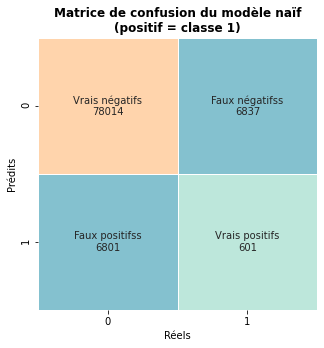

              precision    recall  f1-score   support

           0       0.92      0.92      0.92     84851
           1       0.08      0.08      0.08      7402

    accuracy                           0.85     92253
   macro avg       0.50      0.50      0.50     92253
weighted avg       0.85      0.85      0.85     92253



In [17]:
matrice_de_confusion_naïf = metrics.confusion_matrix(les_valeurs_prédites_modèle_naïf_retenu,
                                                     np.array(y_test))
les_textes = np.array((['Vrais négatifs\n' + str(matrice_de_confusion_naïf[0][0]),
                       'Faux négatifss\n' + str(matrice_de_confusion_naïf[0][1])],
                       ['Faux positifss\n' + str(matrice_de_confusion_naïf[1][0]),
                        'Vrais positifs\n' + str(matrice_de_confusion_naïf[1][1])]),
                       dtype = 'object')

plt.figure(figsize = (5,
                      5))
sns.heatmap(matrice_de_confusion_naïf,
            cmap = 'icefire',
            annot = les_textes,
            cbar = False,
            fmt = '',
            linewidths = .5)
plt.xlabel('Réels')
plt.ylabel('Prédits')
plt.title('Matrice de confusion du modèle naïf\n(positif = classe 1)',
          fontsize = 12,
          fontweight = 'bold')
plt.show()

print(metrics.classification_report(les_valeurs_prédites_modèle_naïf_retenu,
                                                     np.array(y_test)))

In [ ]:
def trace_ROC(le_modèle,
              nom_modèle) :
    y_predits_probabilités = le_modèle.predict_proba(X_test)[ : , 1]
    [taux_de_faux_positifs,taux_de_vrais_positifs, seuil] = metrics.roc_curve(y_test,
                                                                              y_predits_probabilités)
    plt.plot(taux_de_faux_positifs,
             taux_de_vrais_positifs,
             color = 'coral',
             lw = 2)
    plt.xlim([0.0, 
              1.0])
    plt.ylim([0.0,
              1.05])
    plt.xlabel('1 - specificite',
               fontsize = 14)
    plt.ylabel('Sensibilite',
               fontsize = 14)
    plt.title('Courbe ROC ' + nom_modèle,
              fontsize = 12,
              fontweight = 'bold')
    plt.show()

    auc = metrics.auc(taux_de_faux_positifs,
                      taux_de_vrais_positifs)

    print('AUC du {} : {:.2f}'.format(nom_modèle,
                                         auc))

    return auc, taux_de_faux_positifs, taux_de_vrais_positifs, seuil

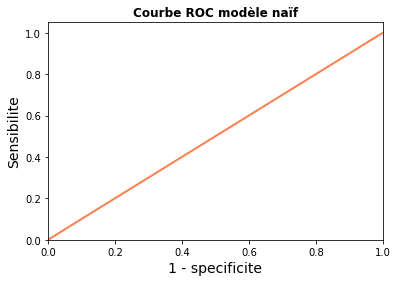

AUC du modèle naïf : 0.50


In [ ]:
auc_naïf, FP_naïf, TP_naïf, seuil_naïf = trace_ROC(le_modèle_naïf_retenu_ajusté,
                     'modèle naïf')

Random Forest

In [20]:
import numpy as np

classificateur_forêt = RandomForestClassifier(random_state = 500)

les_paramètres_forêt = {'n_estimators':[100,
                                        200,
                                        300],
                        'max_features': ['auto'],
                        'max_depth' : [1,
                                       5,
                                       10],
                        'criterion' : ['gini'],
                        'bootstrap' : [True],
                        'oob_score' : [True]}

classificateur_forêt, prédictions_forêt = teste_modèle(X_entrainement, 
                                                       X_test,
                                                       y_entrainement,
                                                       y_test,
                                                       classificateur_forêt, 
                                                       les_paramètres_forêt,
                                                       5,
                                                       cotation)
print('Meilleure précision : ',
      classificateur_forêt.best_score_)
print('Meilleurs paramètres :',
      classificateur_forêt.best_params_)                                                         

Fitting 5 folds for each of 9 candidates, totalling 45 fits


C:\Users\Sdis59\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV 1/5] END bootstrap=True, criterion=gini, max_depth=1, max_features=auto, n_estimators=100, oob_score=True; ROC: (test=0.635) exactitude: (test=0.919) f1: (test=0.000) précision: (test=0.000) sensibilté: (test=0.000) total time=  24.0s


C:\Users\Sdis59\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV 2/5] END bootstrap=True, criterion=gini, max_depth=1, max_features=auto, n_estimators=100, oob_score=True; ROC: (test=0.640) exactitude: (test=0.919) f1: (test=0.000) précision: (test=0.000) sensibilté: (test=0.000) total time=  24.5s


C:\Users\Sdis59\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV 3/5] END bootstrap=True, criterion=gini, max_depth=1, max_features=auto, n_estimators=100, oob_score=True; ROC: (test=0.625) exactitude: (test=0.919) f1: (test=0.000) précision: (test=0.000) sensibilté: (test=0.000) total time=  24.6s


C:\Users\Sdis59\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV 4/5] END bootstrap=True, criterion=gini, max_depth=1, max_features=auto, n_estimators=100, oob_score=True; ROC: (test=0.626) exactitude: (test=0.919) f1: (test=0.000) précision: (test=0.000) sensibilté: (test=0.000) total time=  22.4s


C:\Users\Sdis59\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV 5/5] END bootstrap=True, criterion=gini, max_depth=1, max_features=auto, n_estimators=100, oob_score=True; ROC: (test=0.622) exactitude: (test=0.919) f1: (test=0.000) précision: (test=0.000) sensibilté: (test=0.000) total time=  10.1s


C:\Users\Sdis59\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV 1/5] END bootstrap=True, criterion=gini, max_depth=1, max_features=auto, n_estimators=200, oob_score=True; ROC: (test=0.642) exactitude: (test=0.919) f1: (test=0.000) précision: (test=0.000) sensibilté: (test=0.000) total time=  20.6s


C:\Users\Sdis59\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV 2/5] END bootstrap=True, criterion=gini, max_depth=1, max_features=auto, n_estimators=200, oob_score=True; ROC: (test=0.645) exactitude: (test=0.919) f1: (test=0.000) précision: (test=0.000) sensibilté: (test=0.000) total time=  19.8s


C:\Users\Sdis59\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV 3/5] END bootstrap=True, criterion=gini, max_depth=1, max_features=auto, n_estimators=200, oob_score=True; ROC: (test=0.634) exactitude: (test=0.919) f1: (test=0.000) précision: (test=0.000) sensibilté: (test=0.000) total time=  19.6s


C:\Users\Sdis59\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV 4/5] END bootstrap=True, criterion=gini, max_depth=1, max_features=auto, n_estimators=200, oob_score=True; ROC: (test=0.634) exactitude: (test=0.919) f1: (test=0.000) précision: (test=0.000) sensibilté: (test=0.000) total time=  19.4s


C:\Users\Sdis59\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV 5/5] END bootstrap=True, criterion=gini, max_depth=1, max_features=auto, n_estimators=200, oob_score=True; ROC: (test=0.630) exactitude: (test=0.919) f1: (test=0.000) précision: (test=0.000) sensibilté: (test=0.000) total time=  18.8s


C:\Users\Sdis59\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV 1/5] END bootstrap=True, criterion=gini, max_depth=1, max_features=auto, n_estimators=300, oob_score=True; ROC: (test=0.642) exactitude: (test=0.919) f1: (test=0.000) précision: (test=0.000) sensibilté: (test=0.000) total time=  31.2s


C:\Users\Sdis59\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV 2/5] END bootstrap=True, criterion=gini, max_depth=1, max_features=auto, n_estimators=300, oob_score=True; ROC: (test=0.645) exactitude: (test=0.919) f1: (test=0.000) précision: (test=0.000) sensibilté: (test=0.000) total time=  31.2s


C:\Users\Sdis59\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV 3/5] END bootstrap=True, criterion=gini, max_depth=1, max_features=auto, n_estimators=300, oob_score=True; ROC: (test=0.632) exactitude: (test=0.919) f1: (test=0.000) précision: (test=0.000) sensibilté: (test=0.000) total time=  31.0s


C:\Users\Sdis59\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV 4/5] END bootstrap=True, criterion=gini, max_depth=1, max_features=auto, n_estimators=300, oob_score=True; ROC: (test=0.633) exactitude: (test=0.919) f1: (test=0.000) précision: (test=0.000) sensibilté: (test=0.000) total time=  31.0s


C:\Users\Sdis59\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV 5/5] END bootstrap=True, criterion=gini, max_depth=1, max_features=auto, n_estimators=300, oob_score=True; ROC: (test=0.630) exactitude: (test=0.919) f1: (test=0.000) précision: (test=0.000) sensibilté: (test=0.000) total time=  28.2s


C:\Users\Sdis59\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV 1/5] END bootstrap=True, criterion=gini, max_depth=5, max_features=auto, n_estimators=100, oob_score=True; ROC: (test=0.654) exactitude: (test=0.919) f1: (test=0.000) précision: (test=0.000) sensibilté: (test=0.000) total time=  19.0s


C:\Users\Sdis59\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV 2/5] END bootstrap=True, criterion=gini, max_depth=5, max_features=auto, n_estimators=100, oob_score=True; ROC: (test=0.657) exactitude: (test=0.919) f1: (test=0.000) précision: (test=0.000) sensibilté: (test=0.000) total time=  19.1s


C:\Users\Sdis59\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV 3/5] END bootstrap=True, criterion=gini, max_depth=5, max_features=auto, n_estimators=100, oob_score=True; ROC: (test=0.647) exactitude: (test=0.919) f1: (test=0.000) précision: (test=0.000) sensibilté: (test=0.000) total time=  19.0s


C:\Users\Sdis59\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV 4/5] END bootstrap=True, criterion=gini, max_depth=5, max_features=auto, n_estimators=100, oob_score=True; ROC: (test=0.650) exactitude: (test=0.919) f1: (test=0.000) précision: (test=0.000) sensibilté: (test=0.000) total time=  19.0s


C:\Users\Sdis59\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV 5/5] END bootstrap=True, criterion=gini, max_depth=5, max_features=auto, n_estimators=100, oob_score=True; ROC: (test=0.645) exactitude: (test=0.919) f1: (test=0.000) précision: (test=0.000) sensibilté: (test=0.000) total time=  17.9s


C:\Users\Sdis59\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV 1/5] END bootstrap=True, criterion=gini, max_depth=5, max_features=auto, n_estimators=200, oob_score=True; ROC: (test=0.654) exactitude: (test=0.919) f1: (test=0.000) précision: (test=0.000) sensibilté: (test=0.000) total time=  37.8s


C:\Users\Sdis59\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV 2/5] END bootstrap=True, criterion=gini, max_depth=5, max_features=auto, n_estimators=200, oob_score=True; ROC: (test=0.657) exactitude: (test=0.919) f1: (test=0.000) précision: (test=0.000) sensibilté: (test=0.000) total time=  37.8s


C:\Users\Sdis59\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV 3/5] END bootstrap=True, criterion=gini, max_depth=5, max_features=auto, n_estimators=200, oob_score=True; ROC: (test=0.648) exactitude: (test=0.919) f1: (test=0.000) précision: (test=0.000) sensibilté: (test=0.000) total time=  37.8s


C:\Users\Sdis59\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV 4/5] END bootstrap=True, criterion=gini, max_depth=5, max_features=auto, n_estimators=200, oob_score=True; ROC: (test=0.651) exactitude: (test=0.919) f1: (test=0.000) précision: (test=0.000) sensibilté: (test=0.000) total time=  38.0s


C:\Users\Sdis59\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV 5/5] END bootstrap=True, criterion=gini, max_depth=5, max_features=auto, n_estimators=200, oob_score=True; ROC: (test=0.645) exactitude: (test=0.919) f1: (test=0.000) précision: (test=0.000) sensibilté: (test=0.000) total time=  35.7s


C:\Users\Sdis59\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV 1/5] END bootstrap=True, criterion=gini, max_depth=5, max_features=auto, n_estimators=300, oob_score=True; ROC: (test=0.654) exactitude: (test=0.919) f1: (test=0.000) précision: (test=0.000) sensibilté: (test=0.000) total time=  56.2s


C:\Users\Sdis59\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV 2/5] END bootstrap=True, criterion=gini, max_depth=5, max_features=auto, n_estimators=300, oob_score=True; ROC: (test=0.657) exactitude: (test=0.919) f1: (test=0.000) précision: (test=0.000) sensibilté: (test=0.000) total time= 3.9min


C:\Users\Sdis59\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV 3/5] END bootstrap=True, criterion=gini, max_depth=5, max_features=auto, n_estimators=300, oob_score=True; ROC: (test=0.647) exactitude: (test=0.919) f1: (test=0.000) précision: (test=0.000) sensibilté: (test=0.000) total time= 1.1min


C:\Users\Sdis59\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV 4/5] END bootstrap=True, criterion=gini, max_depth=5, max_features=auto, n_estimators=300, oob_score=True; ROC: (test=0.650) exactitude: (test=0.919) f1: (test=0.000) précision: (test=0.000) sensibilté: (test=0.000) total time= 1.1min


C:\Users\Sdis59\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV 5/5] END bootstrap=True, criterion=gini, max_depth=5, max_features=auto, n_estimators=300, oob_score=True; ROC: (test=0.645) exactitude: (test=0.919) f1: (test=0.000) précision: (test=0.000) sensibilté: (test=0.000) total time= 1.1min


C:\Users\Sdis59\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV 1/5] END bootstrap=True, criterion=gini, max_depth=10, max_features=auto, n_estimators=100, oob_score=True; ROC: (test=0.663) exactitude: (test=0.919) f1: (test=0.000) précision: (test=0.000) sensibilté: (test=0.000) total time=  40.1s


C:\Users\Sdis59\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV 2/5] END bootstrap=True, criterion=gini, max_depth=10, max_features=auto, n_estimators=100, oob_score=True; ROC: (test=0.665) exactitude: (test=0.919) f1: (test=0.000) précision: (test=0.000) sensibilté: (test=0.000) total time=  39.8s


C:\Users\Sdis59\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV 3/5] END bootstrap=True, criterion=gini, max_depth=10, max_features=auto, n_estimators=100, oob_score=True; ROC: (test=0.659) exactitude: (test=0.919) f1: (test=0.000) précision: (test=0.000) sensibilté: (test=0.000) total time=  39.6s


C:\Users\Sdis59\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV 4/5] END bootstrap=True, criterion=gini, max_depth=10, max_features=auto, n_estimators=100, oob_score=True; ROC: (test=0.657) exactitude: (test=0.919) f1: (test=0.000) précision: (test=0.000) sensibilté: (test=0.000) total time=  39.5s


C:\Users\Sdis59\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV 5/5] END bootstrap=True, criterion=gini, max_depth=10, max_features=auto, n_estimators=100, oob_score=True; ROC: (test=0.651) exactitude: (test=0.919) f1: (test=0.000) précision: (test=0.000) sensibilté: (test=0.000) total time=  38.5s


C:\Users\Sdis59\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV 1/5] END bootstrap=True, criterion=gini, max_depth=10, max_features=auto, n_estimators=200, oob_score=True; ROC: (test=0.664) exactitude: (test=0.919) f1: (test=0.000) précision: (test=0.000) sensibilté: (test=0.000) total time= 1.3min


C:\Users\Sdis59\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV 2/5] END bootstrap=True, criterion=gini, max_depth=10, max_features=auto, n_estimators=200, oob_score=True; ROC: (test=0.666) exactitude: (test=0.919) f1: (test=0.000) précision: (test=0.000) sensibilté: (test=0.000) total time= 1.3min


C:\Users\Sdis59\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV 3/5] END bootstrap=True, criterion=gini, max_depth=10, max_features=auto, n_estimators=200, oob_score=True; ROC: (test=0.659) exactitude: (test=0.919) f1: (test=0.000) précision: (test=0.000) sensibilté: (test=0.000) total time=28.5min


C:\Users\Sdis59\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV 4/5] END bootstrap=True, criterion=gini, max_depth=10, max_features=auto, n_estimators=200, oob_score=True; ROC: (test=0.659) exactitude: (test=0.919) f1: (test=0.000) précision: (test=0.000) sensibilté: (test=0.000) total time= 2.0min


C:\Users\Sdis59\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV 5/5] END bootstrap=True, criterion=gini, max_depth=10, max_features=auto, n_estimators=200, oob_score=True; ROC: (test=0.652) exactitude: (test=0.919) f1: (test=0.000) précision: (test=0.000) sensibilté: (test=0.000) total time= 1.7min


C:\Users\Sdis59\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV 1/5] END bootstrap=True, criterion=gini, max_depth=10, max_features=auto, n_estimators=300, oob_score=True; ROC: (test=0.664) exactitude: (test=0.919) f1: (test=0.000) précision: (test=0.000) sensibilté: (test=0.000) total time= 1.8min


C:\Users\Sdis59\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV 2/5] END bootstrap=True, criterion=gini, max_depth=10, max_features=auto, n_estimators=300, oob_score=True; ROC: (test=0.667) exactitude: (test=0.919) f1: (test=0.000) précision: (test=0.000) sensibilté: (test=0.000) total time= 1.9min


C:\Users\Sdis59\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV 3/5] END bootstrap=True, criterion=gini, max_depth=10, max_features=auto, n_estimators=300, oob_score=True; ROC: (test=0.660) exactitude: (test=0.919) f1: (test=0.000) précision: (test=0.000) sensibilté: (test=0.000) total time= 2.7min


C:\Users\Sdis59\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV 4/5] END bootstrap=True, criterion=gini, max_depth=10, max_features=auto, n_estimators=300, oob_score=True; ROC: (test=0.660) exactitude: (test=0.919) f1: (test=0.000) précision: (test=0.000) sensibilté: (test=0.000) total time= 3.0min


C:\Users\Sdis59\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV 5/5] END bootstrap=True, criterion=gini, max_depth=10, max_features=auto, n_estimators=300, oob_score=True; ROC: (test=0.653) exactitude: (test=0.919) f1: (test=0.000) précision: (test=0.000) sensibilté: (test=0.000) total time= 3.0min
Meilleure précision :  0.6606382215647553
Meilleurs paramètres : {'bootstrap': True, 'criterion': 'gini', 'max_depth': 10, 'max_features': 'auto', 'n_estimators': 300, 'oob_score': True}


In [21]:
modèle_forêt_retenu = RandomForestClassifier(random_state = 500,
                                             bootstrap = True,
                                             criterion = 'gini',
                                             max_depth = 10,
                                             max_features = 'auto',
                                             n_estimators = 300,
                                             oob_score = True)

le_modèle_forêt_retenu_ajusté = modèle_forêt_retenu.fit(X_entrainement,
                                                        y_entrainement)
les_valeurs_prédites_modèle_forêt_retenu = le_modèle_forêt_retenu_ajusté.predict(X_test)        

df_résultats_forêt = pd.DataFrame(columns = {'prédits',
                                             'réels'})
df_résultats_forêt['prédits'] = le_modèle_forêt_retenu_ajusté.predict(X_test) 
df_résultats_forêt['réels'] = np.array(y_test)

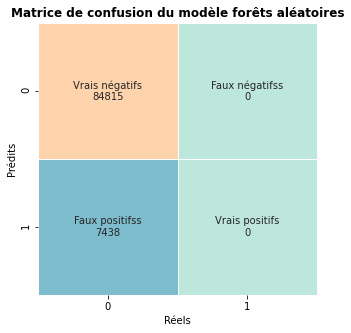

              precision    recall  f1-score   support

           0       1.00      0.92      0.96     92253
           1       0.00      0.00      0.00         0

    accuracy                           0.92     92253
   macro avg       0.50      0.46      0.48     92253
weighted avg       1.00      0.92      0.96     92253



C:\Users\Sdis59\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Sdis59\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Sdis59\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [51]:
matrice_de_confusion_forêt = metrics.confusion_matrix(np.array(y_test), 
                                                      les_valeurs_prédites_modèle_forêt_retenu)
                                                      
les_textes = np.array((['Vrais négatifs\n' + str(matrice_de_confusion_forêt[0][0]),
                       'Faux négatifss\n' + str(matrice_de_confusion_forêt[0][1])],
                       ['Faux positifss\n' + str(matrice_de_confusion_forêt[1][0]),
                        'Vrais positifs\n' + str(matrice_de_confusion_forêt[1][1])]),
                       dtype = 'object')

plt.figure(figsize = (5,
                      5))
sns.heatmap(matrice_de_confusion_forêt,
            cmap = 'icefire',
            annot = les_textes,
            fmt = '',
            cbar = False,
            linewidths = .5)
plt.xlabel('Réels')
plt.ylabel('Prédits')
plt.title('Matrice de confusion du modèle forêts aléatoires',
          fontsize = 12,
          fontweight = 'bold')
plt.show()

print(metrics.classification_report(les_valeurs_prédites_modèle_forêt_retenu,
                                    np.array(y_test)))

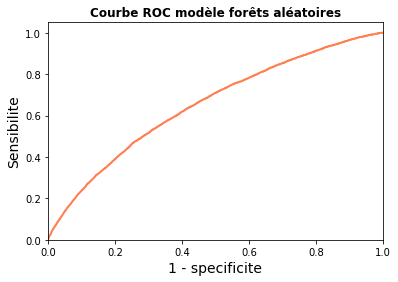

AUC du modèle forêts aléatoires : 0.65


In [52]:
auc_forêt, FP_forêt, TP_forêt, seuil_forêt = trace_ROC(le_modèle_forêt_retenu_ajusté,
                      'modèle forêts aléatoires')

On traite le XGBoost



In [24]:
import numpy as np 

classificateur_XGB = XGBClassifier()

les_paramètres_XGB = {'max_depth': [1,
                                    5,
                                    10],
                      'n_estimators': [100,
                                       200],
                      'learning_rate': [0.1,
                                        0.01],
                      'use_label_encoder' : [False]}

classificateur_XGB, predictions = teste_modèle(X_entrainement, 
                                               X_test,
                                               y_entrainement,
                                               y_test,
                                               classificateur_XGB, 
                                               les_paramètres_XGB,
                                               5,
                                               cotation)

print('Meilleure exactitude : ',
      classificateur_XGB.best_score_)
print('Meilleurs paramètres :',
      classificateur_XGB.best_params_)  

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[07:50:22] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Sdis59\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV 1/5] END learning_rate=0.1, max_depth=1, n_estimators=100, use_label_encoder=False; ROC: (test=0.660) exactitude: (test=0.919) f1: (test=0.000) précision: (test=0.000) sensibilté: (test=0.000) total time=   6.3s
[07:50:28] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Sdis59\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV 2/5] END learning_rate=0.1, max_depth=1, n_estimators=100, use_label_encoder=False; ROC: (test=0.659) exactitude: (test=0.919) f1: (test=0.000) précision: (test=0.000) sensibilté: (test=0.000) total time=   6.1s
[07:50:34] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Sdis59\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV 3/5] END learning_rate=0.1, max_depth=1, n_estimators=100, use_label_encoder=False; ROC: (test=0.658) exactitude: (test=0.919) f1: (test=0.000) précision: (test=0.000) sensibilté: (test=0.000) total time=   7.6s
[07:50:42] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Sdis59\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV 4/5] END learning_rate=0.1, max_depth=1, n_estimators=100, use_label_encoder=False; ROC: (test=0.656) exactitude: (test=0.919) f1: (test=0.000) précision: (test=0.000) sensibilté: (test=0.000) total time=   7.5s
[07:50:50] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Sdis59\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV 5/5] END learning_rate=0.1, max_depth=1, n_estimators=100, use_label_encoder=False; ROC: (test=0.650) exactitude: (test=0.919) f1: (test=0.000) précision: (test=0.000) sensibilté: (test=0.000) total time=   6.5s
[07:50:56] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Sdis59\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV 1/5] END learning_rate=0.1, max_depth=1, n_estimators=200, use_label_encoder=False; ROC: (test=0.668) exactitude: (test=0.919) f1: (test=0.000) précision: (test=0.000) sensibilté: (test=0.000) total time=  12.2s
[07:51:09] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Sdis59\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV 2/5] END learning_rate=0.1, max_depth=1, n_estimators=200, use_label_encoder=False; ROC: (test=0.668) exactitude: (test=0.919) f1: (test=0.000) précision: (test=0.000) sensibilté: (test=0.000) total time=  13.2s
[07:51:22] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Sdis59\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV 3/5] END learning_rate=0.1, max_depth=1, n_estimators=200, use_label_encoder=False; ROC: (test=0.666) exactitude: (test=0.919) f1: (test=0.000) précision: (test=0.000) sensibilté: (test=0.000) total time=  13.8s
[07:51:36] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Sdis59\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV 4/5] END learning_rate=0.1, max_depth=1, n_estimators=200, use_label_encoder=False; ROC: (test=0.666) exactitude: (test=0.919) f1: (test=0.000) précision: (test=0.000) sensibilté: (test=0.000) total time=  14.8s
[07:51:51] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Sdis59\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV 5/5] END learning_rate=0.1, max_depth=1, n_estimators=200, use_label_encoder=False; ROC: (test=0.659) exactitude: (test=0.919) f1: (test=0.000) précision: (test=0.000) sensibilté: (test=0.000) total time=  15.7s
[07:52:07] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Sdis59\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV 1/5] END learning_rate=0.1, max_depth=5, n_estimators=100, use_label_encoder=False; ROC: (test=0.677) exactitude: (test=0.919) f1: (test=0.000) précision: (test=0.000) sensibilté: (test=0.000) total time=  29.8s
[07:52:37] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Sdis59\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV 2/5] END learning_rate=0.1, max_depth=5, n_estimators=100, use_label_encoder=False; ROC: (test=0.679) exactitude: (test=0.919) f1: (test=0.000) précision: (test=0.000) sensibilté: (test=0.000) total time=  25.8s
[07:53:03] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Sdis59\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV 3/5] END learning_rate=0.1, max_depth=5, n_estimators=100, use_label_encoder=False; ROC: (test=0.677) exactitude: (test=0.919) f1: (test=0.000) précision: (test=0.000) sensibilté: (test=0.000) total time=  24.8s
[07:53:28] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Sdis59\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV 4/5] END learning_rate=0.1, max_depth=5, n_estimators=100, use_label_encoder=False; ROC: (test=0.678) exactitude: (test=0.919) f1: (test=0.000) précision: (test=0.000) sensibilté: (test=0.000) total time=  28.7s
[07:53:57] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Sdis59\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV 5/5] END learning_rate=0.1, max_depth=5, n_estimators=100, use_label_encoder=False; ROC: (test=0.671) exactitude: (test=0.919) f1: (test=0.000) précision: (test=0.000) sensibilté: (test=0.000) total time=  24.3s
[07:54:21] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/5] END learning_rate=0.1, max_depth=5, n_estimators=200, use_label_encoder=False; ROC: (test=0.678) exactitude: (test=0.919) f1: (test=0.000) précision: (test=0.000) sensibilté: (test=0.000) total time=  54.6s
[07:55:16] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eva

C:\Users\Sdis59\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV 1/5] END learning_rate=0.01, max_depth=1, n_estimators=100, use_label_encoder=False; ROC: (test=0.600) exactitude: (test=0.919) f1: (test=0.000) précision: (test=0.000) sensibilté: (test=0.000) total time=   9.1s
[08:24:13] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Sdis59\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV 2/5] END learning_rate=0.01, max_depth=1, n_estimators=100, use_label_encoder=False; ROC: (test=0.599) exactitude: (test=0.919) f1: (test=0.000) précision: (test=0.000) sensibilté: (test=0.000) total time=   8.1s
[08:24:21] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Sdis59\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV 3/5] END learning_rate=0.01, max_depth=1, n_estimators=100, use_label_encoder=False; ROC: (test=0.603) exactitude: (test=0.919) f1: (test=0.000) précision: (test=0.000) sensibilté: (test=0.000) total time=   7.5s
[08:24:28] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Sdis59\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV 4/5] END learning_rate=0.01, max_depth=1, n_estimators=100, use_label_encoder=False; ROC: (test=0.600) exactitude: (test=0.919) f1: (test=0.000) précision: (test=0.000) sensibilté: (test=0.000) total time=   7.6s
[08:24:36] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Sdis59\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV 5/5] END learning_rate=0.01, max_depth=1, n_estimators=100, use_label_encoder=False; ROC: (test=0.597) exactitude: (test=0.919) f1: (test=0.000) précision: (test=0.000) sensibilté: (test=0.000) total time=   7.8s
[08:24:44] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Sdis59\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV 1/5] END learning_rate=0.01, max_depth=1, n_estimators=200, use_label_encoder=False; ROC: (test=0.620) exactitude: (test=0.919) f1: (test=0.000) précision: (test=0.000) sensibilté: (test=0.000) total time=  16.5s
[08:25:01] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Sdis59\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV 2/5] END learning_rate=0.01, max_depth=1, n_estimators=200, use_label_encoder=False; ROC: (test=0.613) exactitude: (test=0.919) f1: (test=0.000) précision: (test=0.000) sensibilté: (test=0.000) total time=  17.6s
[08:25:18] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Sdis59\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV 3/5] END learning_rate=0.01, max_depth=1, n_estimators=200, use_label_encoder=False; ROC: (test=0.618) exactitude: (test=0.919) f1: (test=0.000) précision: (test=0.000) sensibilté: (test=0.000) total time=  15.8s
[08:25:34] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Sdis59\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV 4/5] END learning_rate=0.01, max_depth=1, n_estimators=200, use_label_encoder=False; ROC: (test=0.615) exactitude: (test=0.919) f1: (test=0.000) précision: (test=0.000) sensibilté: (test=0.000) total time=  14.7s
[08:25:49] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Sdis59\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV 5/5] END learning_rate=0.01, max_depth=1, n_estimators=200, use_label_encoder=False; ROC: (test=0.612) exactitude: (test=0.919) f1: (test=0.000) précision: (test=0.000) sensibilté: (test=0.000) total time=  17.0s
[08:26:07] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/5] END learning_rate=0.01, max_depth=5, n_estimators=100, use_label_encoder=False; ROC: (test=0.653) exactitude: (test=0.919) f1: (test=0.000) précision: (test=0.000) sensibilté: (test=0.000) total time=  29.7s
[08:26:36] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set e

C:\Users\Sdis59\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV 2/5] END learning_rate=0.01, max_depth=5, n_estimators=100, use_label_encoder=False; ROC: (test=0.653) exactitude: (test=0.919) f1: (test=0.000) précision: (test=0.000) sensibilté: (test=0.000) total time=  24.8s
[08:27:01] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 3/5] END learning_rate=0.01, max_depth=5, n_estimators=100, use_label_encoder=False; ROC: (test=0.651) exactitude: (test=0.919) f1: (test=0.000) précision: (test=0.000) sensibilté: (test=0.000) total time=  28.3s
[08:27:30] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set e

C:\Users\Sdis59\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV 4/5] END learning_rate=0.01, max_depth=5, n_estimators=100, use_label_encoder=False; ROC: (test=0.647) exactitude: (test=0.919) f1: (test=0.000) précision: (test=0.000) sensibilté: (test=0.000) total time=  27.8s
[08:27:58] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Sdis59\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV 5/5] END learning_rate=0.01, max_depth=5, n_estimators=100, use_label_encoder=False; ROC: (test=0.643) exactitude: (test=0.919) f1: (test=0.000) précision: (test=0.000) sensibilté: (test=0.000) total time=  27.0s
[08:28:25] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Sdis59\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV 1/5] END learning_rate=0.01, max_depth=5, n_estimators=200, use_label_encoder=False; ROC: (test=0.660) exactitude: (test=0.919) f1: (test=0.000) précision: (test=0.000) sensibilté: (test=0.000) total time=  54.5s
[08:29:20] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Sdis59\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV 2/5] END learning_rate=0.01, max_depth=5, n_estimators=200, use_label_encoder=False; ROC: (test=0.658) exactitude: (test=0.919) f1: (test=0.000) précision: (test=0.000) sensibilté: (test=0.000) total time=  54.3s
[08:30:14] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Sdis59\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV 3/5] END learning_rate=0.01, max_depth=5, n_estimators=200, use_label_encoder=False; ROC: (test=0.659) exactitude: (test=0.919) f1: (test=0.000) précision: (test=0.000) sensibilté: (test=0.000) total time= 2.5min
[08:32:43] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Sdis59\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV 4/5] END learning_rate=0.01, max_depth=5, n_estimators=200, use_label_encoder=False; ROC: (test=0.654) exactitude: (test=0.919) f1: (test=0.000) précision: (test=0.000) sensibilté: (test=0.000) total time=  40.9s
[08:33:24] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Sdis59\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV 5/5] END learning_rate=0.01, max_depth=5, n_estimators=200, use_label_encoder=False; ROC: (test=0.651) exactitude: (test=0.919) f1: (test=0.000) précision: (test=0.000) sensibilté: (test=0.000) total time=  46.9s
[08:34:12] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/5] END learning_rate=0.01, max_depth=10, n_estimators=100, use_label_encoder=False; ROC: (test=0.655) exactitude: (test=0.919) f1: (test=0.000) précision: (test=0.000) sensibilté: (test=0.000) total time= 1.1min
[08:35:16] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set 

C:\Users\Sdis59\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV 4/5] END learning_rate=0.01, max_depth=10, n_estimators=100, use_label_encoder=False; ROC: (test=0.652) exactitude: (test=0.919) f1: (test=0.000) précision: (test=0.000) sensibilté: (test=0.000) total time= 1.0min
[08:38:15] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 5/5] END learning_rate=0.01, max_depth=10, n_estimators=100, use_label_encoder=False; ROC: (test=0.646) exactitude: (test=0.919) f1: (test=0.002) précision: (test=0.750) sensibilté: (test=0.001) total time= 1.1min
[08:39:19] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set

C:\Users\Sdis59\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV 2/5] END learning_rate=0.01, max_depth=10, n_estimators=200, use_label_encoder=False; ROC: (test=0.660) exactitude: (test=0.919) f1: (test=0.000) précision: (test=0.000) sensibilté: (test=0.000) total time= 2.2min
[08:43:42] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 3/5] END learning_rate=0.01, max_depth=10, n_estimators=200, use_label_encoder=False; ROC: (test=0.663) exactitude: (test=0.919) f1: (test=0.000) précision: (test=0.000) sensibilté: (test=0.000) total time= 2.2min
[08:45:53] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set

C:\Users\Sdis59\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV 4/5] END learning_rate=0.01, max_depth=10, n_estimators=200, use_label_encoder=False; ROC: (test=0.658) exactitude: (test=0.919) f1: (test=0.000) précision: (test=0.000) sensibilté: (test=0.000) total time= 2.1min
[08:47:58] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 5/5] END learning_rate=0.01, max_depth=10, n_estimators=200, use_label_encoder=False; ROC: (test=0.652) exactitude: (test=0.919) f1: (test=0.001) précision: (test=1.000) sensibilté: (test=0.001) total time= 2.3min
[08:50:14] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set

In [25]:
modèle_XGB_retenu = XGBClassifier(random_state = 500,
                                  learning_rate = 0.1,
                                  max_depth = 5,
                                  n_estimators = 200,
                                  use_label_encoder = False)

les_textes = np.array((['Vrais négatifs\n' + str(matrice_de_confusion_forêt[0][0]),
                       'Faux négatifss\n' + str(matrice_de_confusion_forêt[0][1])],
                       ['Faux positifss\n' + str(matrice_de_confusion_forêt[1][0]),
                        'Vrais positifs\n' + str(matrice_de_confusion_forêt[1][1])]),
                       dtype = 'object')

le_modèle_XGB_retenu_ajusté = modèle_XGB_retenu.fit(X_entrainement,
                                                    y_entrainement)
les_valeurs_prédites_modèle_XGB_retenu = le_modèle_XGB_retenu_ajusté.predict(X_test)        

df_résultats_XGB = pd.DataFrame(columns = {'prédits',
                                           'réels'})
df_résultats_XGB['prédits'] = le_modèle_XGB_retenu_ajusté.predict(X_test) 
df_résultats_XGB['réels'] = np.array(y_test)

[08:51:33] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


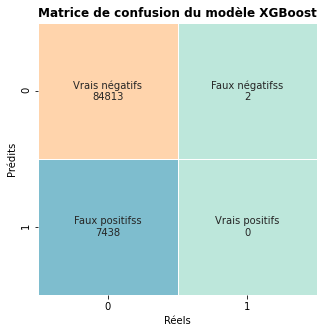

              precision    recall  f1-score   support

           0       1.00      0.92      0.96     92251
           1       0.00      0.00      0.00         2

    accuracy                           0.92     92253
   macro avg       0.50      0.46      0.48     92253
weighted avg       1.00      0.92      0.96     92253



In [26]:
matrice_de_confusion_XGB = metrics.confusion_matrix(np.array(y_test), 
                                                    les_valeurs_prédites_modèle_XGB_retenu)
                                                
les_textes = np.array((['Vrais négatifs\n' + str(matrice_de_confusion_XGB[0][0]),
                       'Faux négatifss\n' + str(matrice_de_confusion_XGB[0][1])],
                       ['Faux positifss\n' + str(matrice_de_confusion_XGB[1][0]),
                        'Vrais positifs\n' + str(matrice_de_confusion_XGB[1][1])]),
                       dtype = 'object')

plt.figure(figsize = (5,
                      5))
sns.heatmap(matrice_de_confusion_XGB,
            cmap = 'icefire',
            annot = les_textes,
            fmt = '',
            cbar = False,
            linewidths = .5)
plt.xlabel('Réels')
plt.ylabel('Prédits')
plt.title('Matrice de confusion du modèle XGBoost',
          fontsize = 12,
          fontweight = 'bold')
plt.show()

print(metrics.classification_report(les_valeurs_prédites_modèle_XGB_retenu,
                                                     np.array(y_test)))

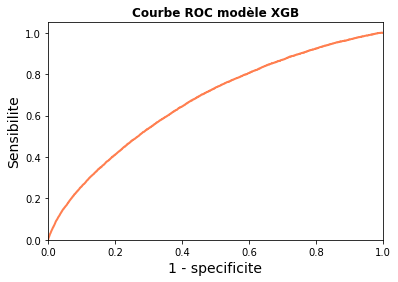

AUC du modèle XGB : 0.67


In [27]:
auc_XGB, FP_XGB, TP_XGB, seuil_XGB = trace_ROC(le_modèle_XGB_retenu_ajusté,
                    'modèle XGB')

Rééquilibrage avec SMOTE et les poids des classes (class weights)

In [28]:
import imblearn

SMOTE

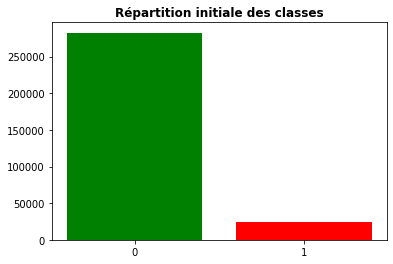

Counter({1: 24825, 0: 282682})

In [29]:
from collections import Counter
from numpy import where

# Etat des données initiales
compteur_initial = Counter(y)
couleurs = ['red',
            'green']
plt.bar(x = compteur_initial.keys(),
        height = compteur_initial.values(),
        color = couleurs)
plt.xticks([0,
            1])
plt.title('Répartition initiale des classes',
          fontsize = 12,
          fontweight = 'bold')
plt.show() 

compteur_initial

In [30]:
# Application de SMOTE
from imblearn.over_sampling import SMOTE

rééchantillonage = SMOTE()
X_SMOTE, y_SMOTE = rééchantillonage.fit_resample(X, y)


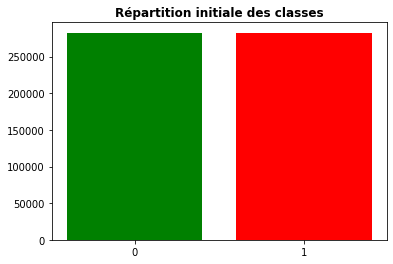

Counter({1: 282682, 0: 282682})

In [31]:
compteur_SMOTE = Counter(y_SMOTE)
couleurs = ['red',
            'green']
plt.bar(x = compteur_SMOTE.keys(),
        height = compteur_SMOTE.values(),
        color = couleurs)
plt.xticks([0,
            1])
plt.title('Répartition initiale des classes',
          fontsize = 12,
          fontweight = 'bold')
plt.show() 

compteur_SMOTE

On va faire tourner les modèles optimaux avec le rééchantillonage.

In [32]:
# Nouveaux jeux de test et d'entrainement
X_entrainement_SMOTE, X_test_SMOTE, y_entrainement_SMOTE, y_test_SMOTE =  model_selection.train_test_split(X_SMOTE,
                                                                                                           y_SMOTE,
                                                                                                           test_size = 0.3,
                                                                                                           random_state = 500)

# Travail des modèles
def dessine_matrice_SMOTE(le_modèle,
                    le_nom_du_modèle) :
    
    le_modèle_ajusté = le_modèle.fit(X_entrainement_SMOTE,
                                     y_entrainement_SMOTE)
    les_valeurs_prédites_du_modèle = le_modèle_ajusté.predict(X_test_SMOTE)

    la_matrice = metrics.confusion_matrix(np.array(y_test_SMOTE), 
                                          les_valeurs_prédites_du_modèle)
    
    les_textes = np.array((['Vrais négatifs\n' + str(la_matrice[0][0]),
                            'Faux négatifss\n' + str(la_matrice[0][1])],
                            ['Faux positifss\n' + str(la_matrice[1][0]),
                            'Vrais positifs\n' + str(la_matrice[1][1])]),
                            dtype = 'object')

    df_résultats = pd.DataFrame(columns = {'prédits',
                                           'réels'})
    df_résultats['prédits'] = le_modèle_ajusté.predict(X_test_SMOTE) 
    df_résultats['réels'] = np.array(y_test_SMOTE)

    plt.figure(figsize = (5,
                        5))
    sns.heatmap(la_matrice,
                cmap = 'icefire',
                annot = les_textes,
                fmt = '',
                cbar = False,
                linewidths = .5)
    plt.xlabel('Réels')
    plt.ylabel('Prédits')
    plt.title('Matrice de confusion du modèle ' + le_nom_du_modèle,
              fontsize = 12,
              fontweight = 'bold')
    plt.show()

    print(metrics.classification_report(les_valeurs_prédites_du_modèle,
                                                     np.array(y_test_SMOTE)))

    return le_modèle_ajusté, la_matrice

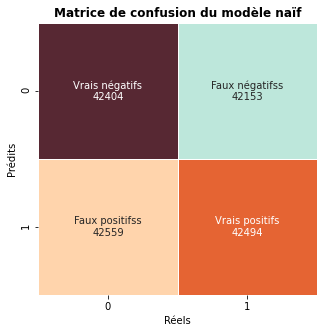

              precision    recall  f1-score   support

           0       0.50      0.50      0.50     84963
           1       0.50      0.50      0.50     84647

    accuracy                           0.50    169610
   macro avg       0.50      0.50      0.50    169610
weighted avg       0.50      0.50      0.50    169610



In [33]:
modèle_naïf_ajusté_SMOTE, la_matrice_SMOTE_modèle_naïf_retenu = dessine_matrice_SMOTE(modèle_naïf_retenu,
                                                            'naïf')

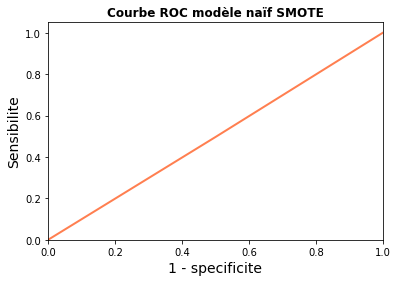

AUC du modèle naïf SMOTE : 0.50


In [34]:
auc_naïf_SMOTE, FP_naïf_SMOTE, TP_naïf_SMOTE, seuil_naïf_SMOTE = trace_ROC(modèle_naïf_ajusté_SMOTE,
                           'modèle naïf SMOTE')


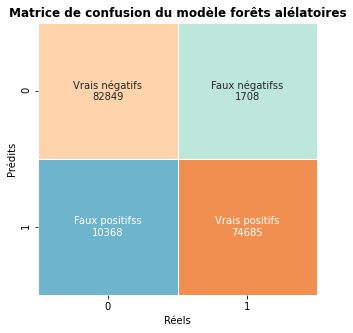

              precision    recall  f1-score   support

           0       0.98      0.89      0.93     93217
           1       0.88      0.98      0.93     76393

    accuracy                           0.93    169610
   macro avg       0.93      0.93      0.93    169610
weighted avg       0.93      0.93      0.93    169610



In [35]:
modèle_forêt_ajusté_SMOTE, la_matrice_SMOTE_modèle_forêt_retenu = dessine_matrice_SMOTE(modèle_forêt_retenu,
                                                             'forêts alélatoires')

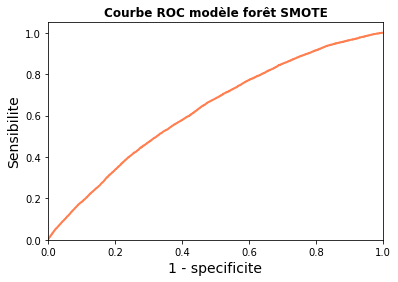

AUC du modèle forêt SMOTE : 0.63


In [36]:
auc_forêt_SMOTE, FP_forêt_SMOTE, TP_forêt_SMOTE, seuil_forêt_SMOTE = trace_ROC(modèle_forêt_ajusté_SMOTE,
                            'modèle forêt SMOTE')

[08:58:35] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


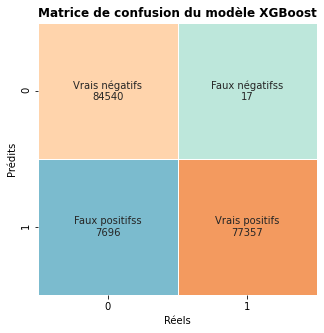

              precision    recall  f1-score   support

           0       1.00      0.92      0.96     92236
           1       0.91      1.00      0.95     77374

    accuracy                           0.95    169610
   macro avg       0.95      0.96      0.95    169610
weighted avg       0.96      0.95      0.95    169610



In [37]:
modèle_XGB_ajusté_SMOTE, la_matrice_SMOTE_modèle_XGB_retenu = dessine_matrice_SMOTE(modèle_XGB_retenu,
                                                           'XGBoost')

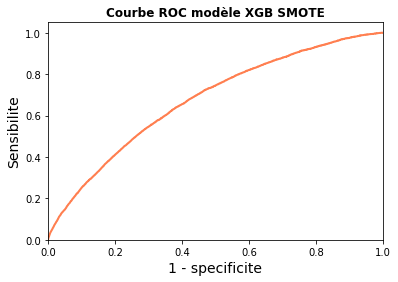

AUC du modèle XGB SMOTE : 0.67


In [38]:
auc_XGB_SMOTE, FP_XGB_SMOTE, TP_XGB_SMOTE, seuil_XGB_SMOTE = trace_ROC(modèle_XGB_ajusté_SMOTE,
                            'modèle XGB SMOTE')

Class weights

In [39]:
from sklearn.utils import class_weight

les_poids_par_classe = class_weight.compute_class_weight('balanced',
                                                          np.unique(y_entrainement),
                                                          y_entrainement)

les_poids = {0 : les_poids_par_classe[0],
             1 : les_poids_par_classe[1]}

les_poids_par_exemple = [les_poids[i] for i in y_entrainement]

C:\Users\Sdis59\anaconda3\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass classes=[0 1], y=59271     0
138703    0
122632    0
149460    0
179062    1
         ..
180808    0
20767     0
281533    0
307009    0
148407    0
Name: TARGET, Length: 215254, dtype: int64 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


In [40]:
def dessine_matrice_CW(le_modèle,
                    le_nom_du_modèle) :
    
    le_modèle_ajusté = le_modèle.fit(X_entrainement,
                                     y_entrainement,
                                     sample_weight = les_poids_par_exemple)
    les_valeurs_prédites_du_modèle = le_modèle_ajusté.predict(X_test)

    la_matrice = metrics.confusion_matrix(np.array(y_test), 
                                          les_valeurs_prédites_du_modèle)
    
    les_textes = np.array((['Vrais négatifs\n' + str(la_matrice[0][0]),
                            'Faux négatifss\n' + str(la_matrice[0][1])],
                            ['Faux positifss\n' + str(la_matrice[1][0]),
                            'Vrais positifs\n' + str(la_matrice[1][1])]),
                            dtype = 'object')

    df_résultats = pd.DataFrame(columns = {'prédits',
                                           'réels'})
    df_résultats['prédits'] = le_modèle_ajusté.predict(X_test) 
    df_résultats['réels'] = np.array(y_test)

    plt.figure(figsize = (5,
                        5))
    sns.heatmap(la_matrice,
                cmap = 'icefire',
                annot = les_textes,
                fmt = '',
                cbar = False,
                linewidths = .5)
    plt.xlabel('Réels')
    plt.ylabel('Prédits')
    plt.title('Matrice de confusion du modèle ' + le_nom_du_modèle,
              fontsize = 12,
              fontweight = 'bold')
    plt.show()

    print(metrics.classification_report(les_valeurs_prédites_modèle_naïf_retenu,
                                                     np.array(y_test)))

    return le_modèle_ajusté

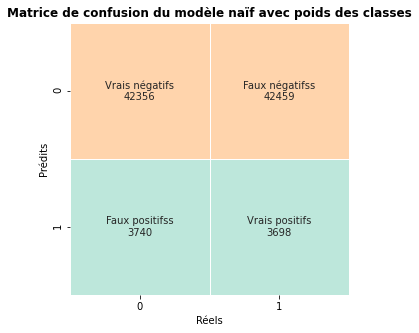

              precision    recall  f1-score   support

           0       0.92      0.92      0.92     84851
           1       0.08      0.08      0.08      7402

    accuracy                           0.85     92253
   macro avg       0.50      0.50      0.50     92253
weighted avg       0.85      0.85      0.85     92253



In [41]:
modèle_naïf_retenu_ajusté_CW = dessine_matrice_CW(modèle_naïf_retenu,
                                            'naïf avec poids des classes')

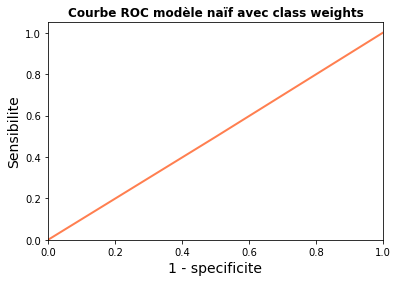

AUC du modèle naïf avec class weights : 0.50


In [42]:
auc_modèle_naïf_CW, FP_modèle_naïf_CW, TP_modèle_naïf_CW, seuil_modèle_naïf_CW = trace_ROC(modèle_naïf_retenu_ajusté_CW,
                            'modèle naïf avec class weights')

XGBoost

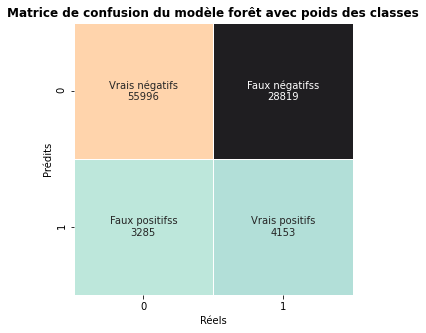

              precision    recall  f1-score   support

           0       0.92      0.92      0.92     84851
           1       0.08      0.08      0.08      7402

    accuracy                           0.85     92253
   macro avg       0.50      0.50      0.50     92253
weighted avg       0.85      0.85      0.85     92253



In [43]:
modèle_forêt_retenu_ajusté_CW = dessine_matrice_CW(modèle_forêt_retenu,
                                                   'forêt avec poids des classes')

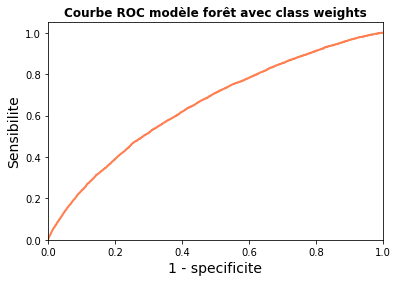

AUC du modèle forêt avec class weights : 0.65


In [44]:
auc_modèle_forêt_CW, FP_modèle_forêt_CW, TP_modèle_forêt_CW, seuil_modèle_forêt_CW = trace_ROC(modèle_forêt_retenu_ajusté_CW,
                               'modèle forêt avec class weights')

[09:03:11] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


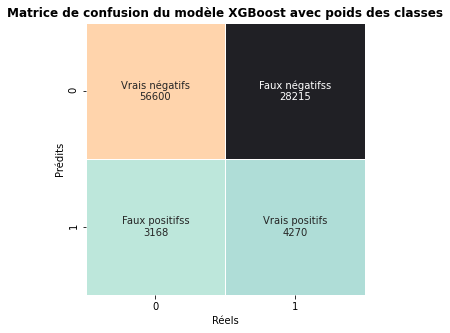

              precision    recall  f1-score   support

           0       0.92      0.92      0.92     84851
           1       0.08      0.08      0.08      7402

    accuracy                           0.85     92253
   macro avg       0.50      0.50      0.50     92253
weighted avg       0.85      0.85      0.85     92253



In [45]:
modèle_XGB_retenu_ajusté_CW = dessine_matrice_CW(modèle_XGB_retenu,
                   'XGBoost avec poids des classes')

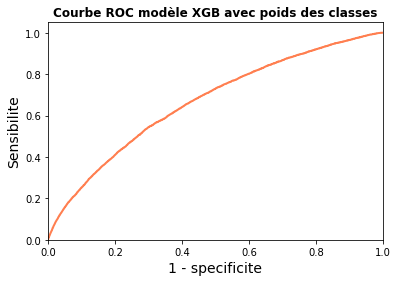

AUC du modèle XGB avec poids des classes : 0.67


In [46]:
auc_modèle_XGB_CW, FP_modèle_XGB_CW, TP_modèle_XGB_CW, seuil_modèle_XGB_CW  = trace_ROC(modèle_XGB_retenu_ajusté_CW,
                       'modèle XGB avec poids des classes')

In [53]:
df_résultats_globaux = pd.DataFrame(index = ['naïf',
                                             'forêts',
                                             'XGB'])
df_résultats_globaux['SMOTE'] = [auc_naïf_SMOTE,
                                 auc_forêt_SMOTE,
                                 auc_XGB_SMOTE]
df_résultats_globaux['CW'] = [auc_modèle_naïf_CW,
                              auc_modèle_forêt_CW,
                              auc_modèle_XGB_CW]
df_résultats_globaux['sans ajustement'] = [auc_naïf,
                                           auc_forêt,
                                           auc_XGB]

In [54]:
df_résultats_globaux

,SMOTE,CW,sans ajustement
naïf,0.498170,0.498285,0.500308
forêts,0.627111,0.651172,0.651172
XGB,0.674465,0.666264,0.668617


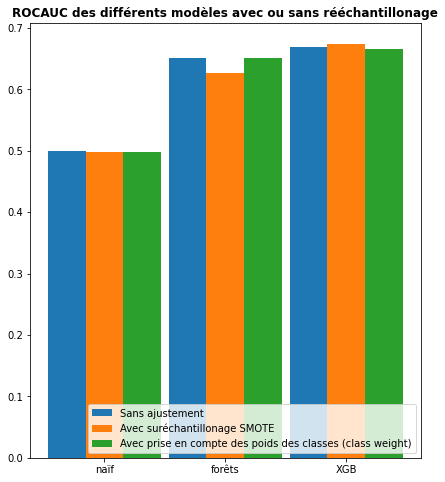

In [55]:
plt.figure(figsize = (7, 8))
plt.bar([0, 1.6, 3.2],
        height = df_résultats_globaux['sans ajustement'].values,
        width = .5,
        label = 'Sans ajustement')
plt.bar([0.5, 2.1, 3.7],
        height = df_résultats_globaux['SMOTE'].values,
        width = .5,
        label = 'Avec suréchantillonage SMOTE')
plt.bar([1, 2.6, 4.2],
        height = df_résultats_globaux['CW'].values,
        width = .5,
        label = 'Avec prise en compte des poids des classes (class weight)')
plt.xticks([0.5, 2.1, 3.7],
           df_résultats_globaux.index)
plt.title('ROCAUC des différents modèles avec ou sans rééchantillonage',
          fontsize = 12,
          fontweight = 'bold')
plt.legend(loc = 'lower right')
plt.show()

Meilleur modèle : XGBOOST avec SMOTE

On va travailler avec le f béta score

In [65]:
from sklearn.metrics import fbeta_score

print(metrics.fbeta_score(y_true = y_test_SMOTE,
                          y_pred = modèle_XGB_ajusté_SMOTE.predict(X_test_SMOTE),
                          beta = 1))

0.716434730641168


In [83]:
FP_XGB_SMOTE[np.min(np.where(FP_XGB_SMOTE > 0.9))]

0.9003124447326534

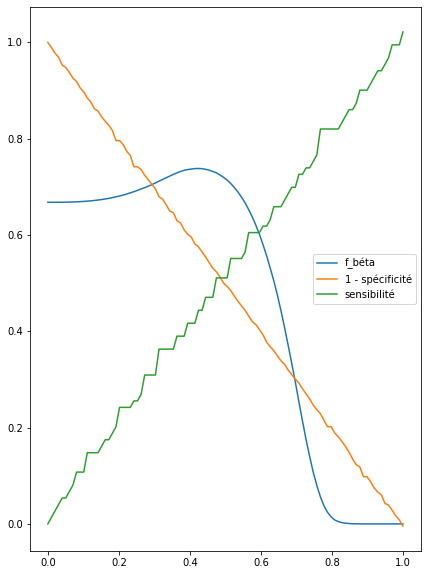

In [149]:
tableau_des_seuils = np.linspace(0,
                                 1,
                                 100)
liste_des_f_béta_score = []
liste_spécificité = []
liste_sensibilité = []

for le_seuil in tableau_des_seuils :
    # Prédits pour un seuil donné
    prédits_selon_seuil = (modèle_XGB_ajusté_SMOTE.predict_proba(X_test_SMOTE) >= le_seuil).astype(int)
    # Calcul du f béta pour un seuil donné
    liste_des_f_béta_score.append(fbeta_score(y_true = y_test_SMOTE,
                                              y_pred = prédits_selon_seuil[ : , 1],
                                              beta = 1))
    # Calcul de la spécificité pour un seuil donné1
    liste_spécificité.append(1 - 100 * FP_XGB_SMOTE[np.min(np.where(100 * FP_XGB_SMOTE >= le_seuil))])
    # Calcul de la sensibilté pour un seuil donné
    liste_sensibilité.append(100 * TP_XGB_SMOTE[np.min(np.where(100 * TP_XGB_SMOTE >= le_seuil))])

plt.figure(figsize = (7, 10))
plt.plot(tableau_des_seuils,
         liste_des_f_béta_score,
         label = 'f_béta')
plt.plot(tableau_des_seuils,
         liste_spécificité,
         label = '1 - spécificité')
plt.plot(tableau_des_seuils,
         liste_sensibilité,
         label = 'sensibilité')
plt.legend()
plt.show()



Importance des caractéristiques

In [156]:
from xgboost import plot_importance
from xgboost import xgb



# print("Feature Importances : ", modèle_XGB_ajusté_SMOTE.feature_importances_)

# plot feature importance
xgb.ggplot.importance(modèle_XGB_ajusté_SMOTE,
                measure = 'frequency')
plt.show()

ImportError: cannot import name 'xgb' from 'xgboost' (C:\Users\Sdis59\anaconda3\lib\site-packages\xgboost\__init__.py)